In [51]:
from dotenv import load_dotenv
from tqdm.notebook import trange, tqdm 
from tqdm.asyncio import tqdm_asyncio
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, OpenAIChatPromptExecutionSettings, AzureTextEmbedding
from semantic_kernel.connectors.ai.chat_completion_client_base import ChatCompletionClientBase
from semantic_kernel.contents import ChatHistory 
from semantic_kernel.core_plugins.text_memory_plugin import TextMemoryPlugin
from semantic_kernel.memory.semantic_text_memory import ( MemoryQueryResult,
    SemanticTextMemory,
)
from semantic_kernel.connectors.memory.azure_cosmosdb_no_sql import AzureCosmosDBNoSQLMemoryStore
from azure.cosmos.aio import ContainerProxy, CosmosClient, DatabaseProxy

import os
import extract_msg
import pandas as pd
import csv
from datetime import datetime
import json
import multiprocessing
import concurrent.futures
import time
import asyncio
import nest_asyncio

nest_asyncio.apply()

# Load environment variables from .env file
load_dotenv()
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DATABASE = os.getenv("COSMOS_DATABASE_NAME")
COSMOS_COLLECTION = os.getenv("COSMOS_COLLECTION_NAME")
MSG_DATA_FOLDER_PATH = "D:\\git\\MailDispatcher\\TestData"
MSG_TEST_FOLDER = "TestData"
MSG_TESTRESULT_FOLDER = "TestResults"
DEBUG = True
print(AZURE_OPENAI_ENDPOINT)
print(AZURE_OPENAI_CHAT_DEPLOYMENT_NAME)
print(COSMOS_DATABASE)


https://openaipamontagsweden.openai.azure.com/
gpt4o
maildispatcherdb


Prompt Collection

In [2]:
PROMPT_AI="""
Sei un esperto smistatore di ticket a partire dal testo di una mail che deve analizzarne il suo contenuto e capire a quale gruppo di supporto inviare il ticket. 
Riceverai in input:
- il testo di una mail in formato html
- il titolo della mail

In base al suo contenuto dovrai restituire solo e soltanto la mail alla quale ridirezionare il ticket. Le mail a disposizione sono le seguenti:
- infrasupport@pippo.it
- appsupport@pippo.it
- databasesupport@pippo.it
- UNKNOWN

Scegli:
- infrasupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a sistemi operativi, componenti hardware dei server, configurazioni dei server, patching e updates dei sistemi operativi e della pila software
- appsupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a troubleshooting di una applicazione, problemi di performance, rallentamenti in produzione di una determinata applicazione, modifica di una configurazione di una applicazione, richiesta di estrazione dei log
- databasesupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a una azione da eseguire su un database, aggiornamento degli indici di un database, analisi di performance delle queries, estrazione di dati da una tabella
- UNKNOWN se non riesci a capire a quale gruppo di supporto inviare il ticket

Devi restituire l'output in formato json che include la mail a cui ridirezionare il ticket nel campo mailToTestResult e il motivo della scelta nel campo reasoning che non DEVE includere virgole o altri caratteri che non siano alfanumerici. NON INCLUDERE ALTRO TESTO ALL'INFUORI DELLA MAIL.
L'output che devi restituire è:
{
  ""mailToTestResult"": ""<mail a cui ridirezionare il ticket>""
  ""reasoning"": ""<motivazione della scelta>""
}

Di seguito le informazioni su cui eseguire le analisi:
"""

PROMPT_EMBEDDING="""
Sei un esperto smistatore di ticket a partire dal testo di una mail che deve analizzarne il suo contenuto e capire a quale gruppo di supporto inviare il ticket. 
Riceverai in input:
- il testo di una mail in formato html
- il titolo della mail

In base al suo contenuto dovrai restituire solo e soltanto la mail alla quale ridirezionare il ticket. Le mail a disposizione sono le seguenti:
- infrasupport@pippo.it
- appsupport@pippo.it
- databasesupport@pippo.it
- UNKNOWN

Scegli:
- infrasupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a sistemi operativi, componenti hardware dei server, configurazioni dei server, patching e updates dei sistemi operativi e della pila software
- appsupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a troubleshooting di una applicazione, problemi di performance, rallentamenti in produzione di una determinata applicazione, modifica di una configurazione di una applicazione, richiesta di estrazione dei log
- databasesupport@pippo.it se il contenuto o il titolo della mail hanno riferimenti a una azione da eseguire su un database, aggiornamento degli indici di un database, analisi di performance delle queries, estrazione di dati da una tabella
- UNKNOWN se non riesci a capire a quale gruppo di supporto inviare il ticket

Devi restituire l'output in formato json che include la mail a cui ridirezionare il ticket nel campo mailToTestResult e il motivo della scelta nel campo reasoning che non DEVE includere virgole o altri caratteri che non siano alfanumerici. NON INCLUDERE ALTRO TESTO ALL'INFUORI DELLA MAIL.
L'output che devi restituire è:
{
  ""mailToTestResult"": ""<mail a cui ridirezionare il ticket>""
  ""reasoning"": ""<motivazione della scelta>""
}

In aggiunta ti verrà fornito il risultato di una ricerca vettoriale di similarità e puoi aiutarti con quella per scegliere la mail a cui ridirezionare il ticket.

Di seguito le informazioni su cui eseguire le analisi:
"""


Define common functions

In [3]:
# Define functions
def list_files_with_extension(folder, extension):
    return [f for f in os.listdir(folder) if f.endswith(extension)]

def load_msgs(folder_name):
    file_collection = []
    files = list_files_with_extension(folder_name, ".msg")

    # Iterate over each file
    for file_name in files:
        #debug("Processing msg: ", file_name)
        file_path = os.path.join(folder_name, file_name)   
        with extract_msg.openMsg(file_path) as msg:
            file_collection.append({"filename": f"{file_name}", "msgid": f"{msg.messageId}", "sender": f"{msg.sender}", "to": f"{msg.to}", "subject": f"{msg.subject}", "body": f"{msg.body}", "htmlbody": f"{msg.htmlBody}"})   
    return file_collection

def debug(message):
    if(DEBUG):
        print(message)
    



Initalize SemanticKernel 

In [4]:
chat_completion_service = AzureChatCompletion()
embedding_service = AzureTextEmbedding(service_id="text_embedding")   

# Initialize the kernel
kernel = Kernel()

# Add the chat completion service created above to the kernel
kernel.add_service(chat_completion_service)
kernel.add_service(embedding_service)

# Retrieve the chat completion service by type
chat_completion_service = kernel.get_service(type=ChatCompletionClientBase)
execution_settings = OpenAIChatPromptExecutionSettings(temperature=0, maxtokens=1000)
# memory store
#https://github.com/microsoft/semantic-kernel/blob/main/python/samples/concepts/memory/memory.py
cosmosclient = CosmosClient.from_connection_string(COSMOS_CONNECTION_STRING)
indexing_policy = {
    "vectorIndexes": [
        {
            "path": "/embedding",
            "type": "diskANN",
            "quantizationByteSize": 96,
            "indexingSearchListSize": 100
        }
    ]
}
vector_embedding_policy = { 
    "vectorEmbeddings": [ 
        { 
            "path": "/embedding", 
            "dataType": "float32", 
            "distanceFunction": "cosine", 
            "dimensions": 1536 
        }
    ]    
}
cosmos_container_properties = {
      "partition_key": "/key"
}
noSqlMemoryStore = AzureCosmosDBNoSQLMemoryStore(cosmosclient, COSMOS_DATABASE, "/key", vector_embedding_policy, indexing_policy, cosmos_container_properties )
await noSqlMemoryStore.create_collection(COSMOS_COLLECTION)
collectionname = await noSqlMemoryStore.does_collection_exist(COSMOS_COLLECTION)
print(f"Collection {COSMOS_COLLECTION} is present: {collectionname}")
memory = SemanticTextMemory(storage=noSqlMemoryStore, embeddings_generator=kernel.get_service("text_embedding"))

async def get_correct_mail_from_msg(msg):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT_AI}
    Titolo della mail: {msg.subject}
    Contenuto della mail: {msg.body}"""

    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    debug(f"Execution time for {msg.msgid}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.msgid} - PromptTokens: {response.metadata["usage"].prompt_tokens} CompletionTokens: {response.metadata["usage"].completion_tokens}")
    return response 

async def get_embeddings(msg):
    start = time.time()
    embeddings = await memory.search(COSMOS_COLLECTION, f"{msg.subject} {msg.body}", limit=3)
    end = time.time()
    debug(f"Execution time for {msg.msgid}: {(end-start) * 10**3} ms")
    return embeddings

async def get_correct_mail_with_embeddings_from_msg(msg, embeddings):
    start = time.time()
    chat_history = ChatHistory()
    prompt = f"""{PROMPT_AI}
    Titolo della mail: {msg.subject}
    Contenuto della mail: {msg.body}

    E il risultato della ricerca vettoriale:""" 
    for results in embeddings:
        prompt = f"{prompt} \n {results.description} - {results.relevance}" 
    #debug(f"Prompt: {prompt}")
    chat_history.add_user_message(prompt)

    response = await chat_completion_service.get_chat_message_content(
        chat_history=chat_history,
        settings=execution_settings
    )
    end = time.time()
    debug(f"Execution time for {msg.msgid}: {(end-start) * 10**3} ms")
    debug(f"Token consumption for {msg.msgid} - PromptTokens: {response.metadata["usage"].prompt_tokens} CompletionTokens: {response.metadata["usage"].completion_tokens}")
    return response 

Collection mailembeddings is present: True


Import email data into collection

In [5]:
msg_collection = load_msgs(MSG_DATA_FOLDER_PATH)
pd.DataFrame(msg_collection, columns=["filename", "msgid", "subject"])

,filename,msgid,subject
0,RE_ Availability Confirmation for_ ENT _ Azure...,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,RE: Availability Confirmation for: ENT | Azure...
1,_ESTERNO_ Patching sistemi operativi su vm win...,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,[ESTERNO] Patching sistemi operativi su vm win...
2,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,[ESTERNO] Rallentamenti sull'applicazione PDP
3,_ESTERNO_ Test messaggio mail dispatcher.msg,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,[ESTERNO] Test messaggio mail dispatcher


Init CSV Data for mapping msg with expected result (execute only ONE time if you have new test data)

In [7]:
# take test collection and write to csv only field id, subject and an empty expected result field
df = pd.DataFrame(msg_collection, columns=["msgid", "filename"])
df["expectedresult"] = None
df["result"] = None
df["testresult"]   = None
df["reasoning"] = None
df.to_csv(f"{MSG_TEST_FOLDER}\\test_collection.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)
df



,msgid,filename,expectedresult,result,testresult,reasoning
0,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,RE_ Availability Confirmation for_ ENT _ Azure...,None,None,None,None
1,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,_ESTERNO_ Patching sistemi operativi su vm win...,None,None,None,None
2,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,None,None,None,None
3,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,_ESTERNO_ Test messaggio mail dispatcher.msg,None,None,None,None


Merge Test Collection Data with msg mails

In [6]:
testdatadf = pd.read_csv(f"{MSG_TEST_FOLDER}\\test_collection_data.csv", dtype='string')
df = pd.DataFrame(msg_collection)
testdata_merged = df.merge(testdatadf[['msgid', 'expectedresult', 'result', 'testresult', 'reasoning']], on='msgid')
testdata_merged.head()

,filename,msgid,sender,to,subject,body,htmlbody,expectedresult,result,testresult,reasoning
0,RE_ Availability Confirmation for_ ENT _ Azure...,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,"""Marius-Daniel Bortos (Majorel Muenster GmbH)""...",Lorenzo Repichini <lorenzo.repichini@microsoft...,RE: Availability Confirmation for: ENT | Azure...,None,"b'<html xmlns:v=""urn:schemas-microsoft-com:vml...",UNKNOWN,<NA>,<NA>,<NA>
1,_ESTERNO_ Patching sistemi operativi su vm win...,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Patching sistemi operativi su vm win...,Si richiede con la presente il patching dei si...,"b'<div dir=""ltr"">Si richiede con la presente i...",infrasupport@pippo.it,<NA>,<NA>,<NA>
2,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Rallentamenti sull'applicazione PDP,L'applicazione PDP a partire dal giorno 5/1/20...,"b'<div dir=""ltr"">L\'applicazione PDP a partire...",appsupport@pippo.it,<NA>,<NA>,<NA>
3,_ESTERNO_ Test messaggio mail dispatcher.msg,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,Paolo Montagna <paolomontagna@gmail.com>,pamontag@microsoft.com,[ESTERNO] Test messaggio mail dispatcher,Test messaggio test\r\n,"b'<div dir=""ltr"">Test messaggio test</div>\n'",databasesupport@pippo.it,<NA>,<NA>,<NA>


Init Container Data (only ONCE)

In [87]:
# iterate over the testdata_merged and call memory.save_information with cosmos_collection, subject concatenated with body, msgid and expected result
for index, row in tqdm(testdata_merged.iterrows(), total=testdata_merged.shape[0], desc="Processing embeddings for test data..."):
    await memory.save_information(COSMOS_COLLECTION, f"{row['subject']} {row['body']}", row['msgid'], row['expectedresult'])
 


Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000021FEEF3C2C0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000021FEED65E20>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000021FEF6FF380>


{"text": "[ESTERNO] Rallentamenti sull'applicazione PDP L'applicazione PDP a partire dal giorno 5/1/2025 sta rispondendo lentamente e gli utenti stanno contattando il supporto di primo livello.\r\nPotreste verificare?\r\n", "description": "appsupport@pippo.it", "additional_metadata": null}
0.392706056087505
{"text": "[ESTERNO] Patching sistemi operativi su vm winxaix2012a e winxaix2012b Si richiede con la presente il patching dei sistemi operativi sulle macchine virtuali winxaix2012a e winxaix2012b\r\nGrazie\r\n", "description": "infrasupport@pippo.it", "additional_metadata": null}
0.2970577786036232
{"text": "[ESTERNO] Test messaggio mail dispatcher Test messaggio test\r\n", "description": "databasesupport@pippo.it", "additional_metadata": null}
0.2895865890109621


Test Data with Prompt and Embeddings (Parallel Processing)

In [7]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row):    
    jsonresult = await get_correct_mail_from_msg(row)
    jsonresult = json.loads(jsonresult.content)
    result = {
        'index': index,
        'result': jsonresult["mailToTestResult"],
        'testresult': "PASSED" if jsonresult["mailToTestResult"] == row['expectedresult'] else "FAILED",
        'reasoning': jsonresult["reasoning"]
    }
    return result

promptai_testdata = testdata_merged.copy(deep=True)

# Get the number of CPUs
num_cpus = multiprocessing.cpu_count()
debug(f'"Executing on {num_cpus} CPUs"')
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
    futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
    for result in futures:        
        promptai_testdata.at[result['index'], 'result'] = result['result']
        promptai_testdata.at[result['index'], 'testresult'] = result['testresult']
        promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptAI = pd.DataFrame(promptai_testdata, columns=["msgid", "filename", "expectedresult", "result", "testresult", "reasoning"])
outputPromptAI.head()

"Executing on 8 CPUs"


Processing msg data...:   0%|          | 0/4 [00:00<?, ?it/s]

Execution time for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com>: 1349.1756916046143 ms
Token consumption for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com> - PromptTokens: 526 CompletionTokens: 42
Execution time for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com>: 1522.2361087799072 ms
Token consumption for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> - PromptTokens: 521 CompletionTokens: 44
Execution time for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com>: 2283.8876247406006 ms
Token consumption for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> - PromptTokens: 481 CompletionTokens: 125
Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 2633.706569671631 ms
Token consumption for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> - PromptTokens: 498 CompletionTokens: 125
Tes

,msgid,filename,expectedresult,result,testresult,reasoning
0,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,RE_ Availability Confirmation for_ ENT _ Azure...,UNKNOWN,UNKNOWN,PASSED,Il contenuto e il titolo della mail non conten...
1,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,_ESTERNO_ Patching sistemi operativi su vm win...,infrasupport@pippo.it,infrasupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
2,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,appsupport@pippo.it,appsupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
3,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,_ESTERNO_ Test messaggio mail dispatcher.msg,databasesupport@pippo.it,UNKNOWN,FAILED,Il contenuto e il titolo della mail non conten...


Test Results (Prompt)

Number of tests: 4


testresult
PASSED    75.0%
FAILED    25.0%
Name: proportion, dtype: object

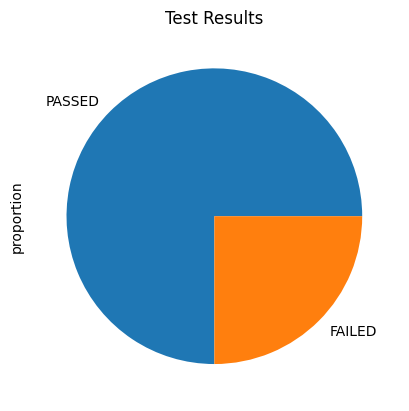

In [8]:
now = datetime.now()

outputPromptAI.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_promptai_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)


outputPromptAI.testresult.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptAI)
print(f"Number of tests: {row_count}")
outputPromptAI.testresult.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Test Data with Prompt and Embeddings (Parallel Processing)

In [52]:
promptai_testdata = testdata_merged.copy(deep=True)
# WARNING: IT IS NOT POSSIBLE TO CALL MEMORY SEARCH WITH ASYNCIO, SO WE NEED TO GET THE EMBEDDINGS BEFOREHAND USING NEST_ASYNCIO AND ASYNCIO.GATHER
# iterate over the promptai_testadata and call the function get_embeddings with the row data. Take the result and put into a dictionary with the msgid as key and the result as value
async def generate_embedding(row): 
    print(f"Task {row[1].msgid} started")
    result = await get_embeddings(row[1])
    print(f"Task {row[1].msgid} completed. Result: {result}")
    return result

async def generate_embeddings():    
    print("Starting tasks") 
    promptai_testdata['embeddings'] = await tqdm_asyncio.gather(*(generate_embedding(v) for v in promptai_testdata.iterrows()))

start = time.time()
asyncio.run(generate_embeddings())
promptai_testdata.head()
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")

Starting tasks


  0%|          | 0/4 [00:00<?, ?it/s]

Task <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> started
Task <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> started
Task <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> started
Task <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com> started


 75%|███████▌  | 3/4 [00:02<00:00,  1.80it/s]

Execution time for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com>: 1896.320104598999 ms
Task <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> completed. Result: [<semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5DB7530>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5DB66C0>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5DB4B00>]
Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 1950.279712677002 ms
Task <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> completed. Result: [<semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5248D70>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB524A0F0>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5DB4F80>]
Execution 

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

Execution time for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com>: 2240.6070232391357 ms
Task <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> completed. Result: [<semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB524AB10>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5249130>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5248140>]
Test Execution time: 2251.6069412231445 ms


In [53]:
def run_async_method(index, row):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    result = loop.run_until_complete(process_row(index, row))
    loop.close()
    return result

async def process_row(index, row): 
    jsonresult = await get_correct_mail_with_embeddings_from_msg(row,row['embeddings'])
    jsonresult = json.loads(jsonresult.content)
    result = {
        'index': index,
        'result': jsonresult["mailToTestResult"],
        'testresult': "PASSED" if jsonresult["mailToTestResult"] == row['expectedresult'] else "FAILED",
        'reasoning': jsonresult["reasoning"]
    }
    return result

# Get the number of CPUs
num_cpus = multiprocessing.cpu_count()
debug(f'"Executing on {num_cpus} CPUs"')
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
    futures = list(executor.map(lambda x: run_async_method(*x), tqdm(promptai_testdata.iterrows(), total=promptai_testdata.shape[0], desc="Processing msg data...")))
    for result in futures:        
        promptai_testdata.at[result['index'], 'result'] = result['result']
        promptai_testdata.at[result['index'], 'testresult'] = result['testresult']
        promptai_testdata.at[result['index'], 'reasoning'] = result['reasoning']
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")
outputPromptEmbeddings = pd.DataFrame(promptai_testdata, columns=["msgid", "filename", "expectedresult", "result", "testresult", "reasoning"])
outputPromptEmbeddings.head()

"Executing on 8 CPUs"


Processing msg data...:   0%|          | 0/4 [00:00<?, ?it/s]

Execution time for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com>: 1102.895975112915 ms
Token consumption for <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> - PromptTokens: 578 CompletionTokens: 42
Execution time for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com>: 1183.335542678833 ms
Token consumption for <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> - PromptTokens: 537 CompletionTokens: 45
Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 1209.4814777374268 ms
Token consumption for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> - PromptTokens: 549 CompletionTokens: 41
Execution time for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com>: 1414.3342971801758 ms
Token consumption for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com> - PromptTokens: 582 CompletionTokens: 42
Test E

,msgid,filename,expectedresult,result,testresult,reasoning
0,<VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR8...,RE_ Availability Confirmation for_ ENT _ Azure...,UNKNOWN,UNKNOWN,PASSED,Il contenuto della mail non fornisce informazi...
1,<CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9z...,_ESTERNO_ Patching sistemi operativi su vm win...,infrasupport@pippo.it,infrasupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
2,<CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4...,_ESTERNO_ Rallentamenti sull'applicazione PDP.msg,appsupport@pippo.it,appsupport@pippo.it,PASSED,Il titolo e il contenuto della mail fanno rife...
3,<CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bV...,_ESTERNO_ Test messaggio mail dispatcher.msg,databasesupport@pippo.it,databasesupport@pippo.it,PASSED,Il risultato della ricerca vettoriale indica c...


Test Results (Prompt with Embeddings)

Number of tests: 4


testresult
PASSED    100.0%
Name: proportion, dtype: object

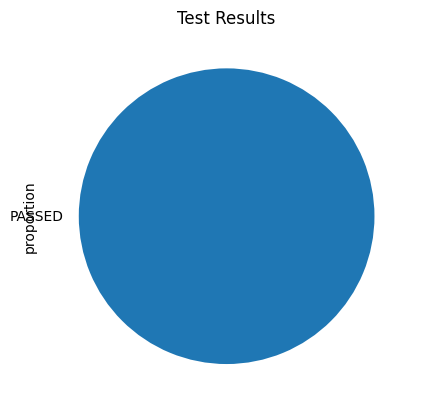

In [54]:
now = datetime.now()

outputPromptEmbeddings.to_csv(f"{MSG_TESTRESULT_FOLDER}\\test_embeddings_{now.strftime('%Y%m%d%H%M%S')}.csv", mode='wb', index=False, quoting=csv.QUOTE_NONNUMERIC)


outputPromptEmbeddings.testresult.value_counts(normalize=True).plot(kind='pie', title='Test Results')
row_count = len(outputPromptEmbeddings)
print(f"Number of tests: {row_count}")
outputPromptEmbeddings.testresult.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

In [44]:
async def generate_embedding(row): 
    print(f"Task {row[1].msgid} started")
    result = await get_embeddings(row[1])
    print(f"Task {row[1].msgid} completed. Result: {result}")
    return result

async def generate_embeddings():
    
    print("Starting tasks") 
    promptai_testdata['embeddings'] = await asyncio.gather(*(generate_embedding(v) for v in promptai_testdata.iterrows()))
    
 

start = time.time()
asyncio.run(generate_embeddings())
promptai_testdata.head()
end = time.time()
debug(f"Test Execution time: {(end-start) * 10**3} ms")

        


Starting tasks
Task <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> started
Task <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com> started
Task <CAFbA+2sdtxAOvfjofHXXs=L=+tZsAUQ3h9Q0QapZhEY4+Cbmnw@mail.gmail.com> started
Task <CAFbA+2t_3QLx3eKoYLGkDefoe6Y0GkuB8AhCwiWhq8bVVCOzeg@mail.gmail.com> started
Execution time for <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com>: 1851.0353565216064 ms
Task <VI0PR83MB073893769A00EA779B6DF285E01B2@VI0PR83MB0738.EURPRD83.prod.outlook.com> completed. Result: [<semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5113320>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB51103B0>, <semantic_kernel.memory.memory_query_result.MemoryQueryResult object at 0x0000019DB5113560>]
Execution time for <CAFbA+2v9_r2o86dA3bS94mkNe9sv56y3LTaG3xAi0e9zs3fDBw@mail.gmail.com>: 1920.6123352050781 ms
Task <CAFbA+2v9_r2o86dA3bS